In [1]:
import shap
import eli5
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib
import xgboost
plt.style.use('ggplot')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.classifier import ClassBalance, ClassPredictionError, ConfusionMatrix, ClassificationReport, ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.features import FeatureImportances
from sklearn.preprocessing import RobustScaler
from pickle import dump,load #librerias para guardar y cargar el mejor modelo

# LOAD DATA

### LOAD DESCRIPTION LABELS

In [2]:
description_labels = pd.read_csv('C:/Users/eortiz/Documents/PROJECT 4/columns_description.csv', sep=',', encoding='mac_roman')
description_labels = description_labels[description_labels['Table']== 'application_data']
del description_labels['Number']
del description_labels['Table']
description_labels.head(123)

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [3]:
pd.set_option('display.max_colwidth', None)  
print(description_labels['Description'][description_labels['Row'] == 'WEEKDAY_APPR_PROCESS_START'])

32    On which day of the week did the client apply for the loan
Name: Description, dtype: object


In [4]:
description_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Row          122 non-null    object
 1   Description  122 non-null    object
 2   Special      56 non-null     object
dtypes: object(3)
memory usage: 3.8+ KB


In [5]:
description_labels[description_labels['Special'].notnull()]

,Row,Description,Special
16,REGION_POPULATION_RELATIVE,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
17,DAYS_BIRTH,Client's age in days at the time of application,time only relative to the application
18,DAYS_EMPLOYED,How many days before the application the person started current employment,time only relative to the application
19,DAYS_REGISTRATION,How many days before the application did client change his registration,time only relative to the application
20,DAYS_ID_PUBLISH,How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
33,HOUR_APPR_PROCESS_START,Approximately at what hour did the client apply for the loan,rounded
41,EXT_SOURCE_1,Normalized score from external data source,normalized
42,EXT_SOURCE_2,Normalized score from external data source,normalized
43,EXT_SOURCE_3,Normalized score from external data source,normalized
44,APARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized


### LOAD DATA

In [6]:
df= pd.read_csv('C:/Users/eortiz/Documents/PROJECT 4/application_data.csv', sep =',',decimal ='.')

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [8]:
object_type=['FLAG_MOBIL','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','REG_REGION_NOT_LIVE_REGION',
             'LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
             'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
             'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
             'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
             'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
            ]

In [9]:
for col in object_type:
    df[col]=df[col].astype('object')

In [10]:
df.describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,...,307511.0,307511.0,307511.0,307511.0,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,...,305011.0,307328.0,307355.0,307408.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,...,NaN,NaN,NaN,NaN,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,NaN,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,...,NaN,NaN,NaN,NaN,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


# DATA ANALYSIS

In [11]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing',ascending=False, inplace=True)
missing_value_df.reset_index(drop=True, inplace=True)
missing_value_df.head()

,column_name,percent_missing
0,COMMONAREA_MEDI,69.872297
1,COMMONAREA_AVG,69.872297
2,COMMONAREA_MODE,69.872297
3,NONLIVINGAPARTMENTS_MODE,69.432963
4,NONLIVINGAPARTMENTS_AVG,69.432963


In [12]:
most_mising_values=missing_value_df[missing_value_df['percent_missing'] > 50]
most_mising_values

,column_name,percent_missing
0,COMMONAREA_MEDI,69.872297
1,COMMONAREA_AVG,69.872297
2,COMMONAREA_MODE,69.872297
3,NONLIVINGAPARTMENTS_MODE,69.432963
4,NONLIVINGAPARTMENTS_AVG,69.432963
5,NONLIVINGAPARTMENTS_MEDI,69.432963
6,FONDKAPREMONT_MODE,68.386172
7,LIVINGAPARTMENTS_MODE,68.354953
8,LIVINGAPARTMENTS_AVG,68.354953
9,LIVINGAPARTMENTS_MEDI,68.354953


In [13]:
#drop non usable
for col in most_mising_values['column_name']: del df[col]

In [14]:
df.shape

(307511, 81)

## TARGET

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


0    282686
1     24825
Name: TARGET, dtype: int64

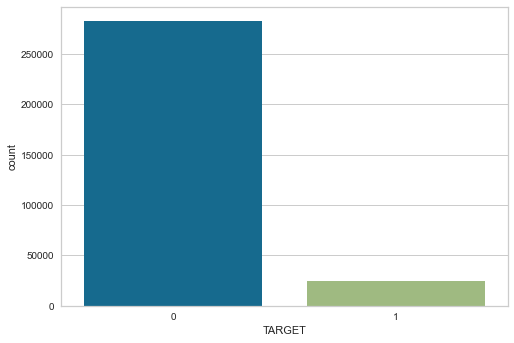

In [15]:
sns.countplot(df['TARGET'])
df['TARGET'].value_counts()

**We are working with an imbalance dataset with 8% bad clients**

## CATEGORICAL FEATURES

In [16]:
categorical_features = df.select_dtypes("object").columns.to_list()
print(categorical_features,len(categorical_features))

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'] 45


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

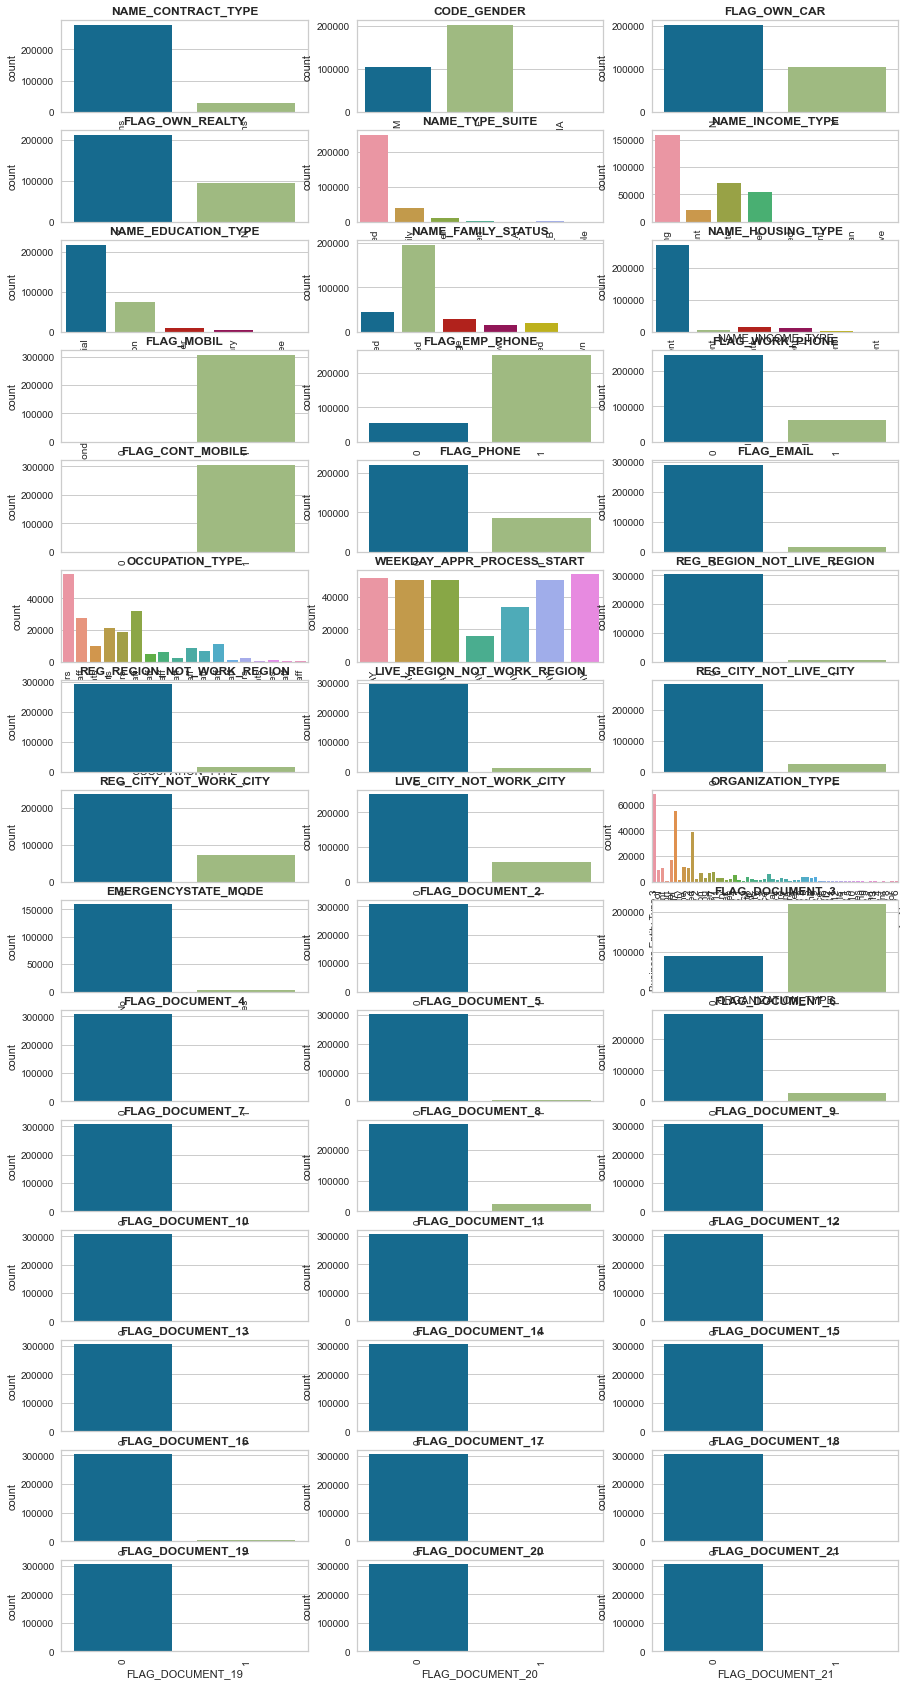

In [17]:
fig, ax = plt.subplots(15, 3, figsize=(15, 30))
#fig.suptitle('CATEGORICAL FEATURES')
for variable, subplot in zip(categorical_features, ax.flatten()):
    ax=sns.countplot(df[variable], ax=subplot)
    #ax.set_title(variable)
    ax=ax.set_title(variable,fontsize = 12, fontweight='bold')
    
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.tight_layout()

In [18]:
df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [19]:
df['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

### DATA PREPARATION CATEGORICAL FEATURES

In [20]:
## DROP FEATURES THAT HAVE HIGH % MISSING VALUES OR NOT RELATED TO CREDIT RISK

non_usable_categorical=['NAME_TYPE_SUITE','EMERGENCYSTATE_MODE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                        'OCCUPATION_TYPE','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_CONT_MOBILE','REG_REGION_NOT_LIVE_REGION',
                        'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_2',
                        'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
                        'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
                        'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                        'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','REG_REGION_NOT_WORK_REGION']


for col in non_usable_categorical: del df[col]

In [21]:
#CLEAN NAN ROWS
df.drop(df.loc[df['CODE_GENDER']=='XNA'].index, inplace=True)
df.drop(df.loc[df['NAME_FAMILY_STATUS']=='Unknown'].index, inplace=True)

In [22]:
#REDUCE LEVELS
df['NAME_FAMILY_STATUS'].replace({'Civil marriage':'Married','Single / not married':'Single','Separated':'Single','Widow':'Single'},inplace=True)
df['NAME_INCOME_TYPE'].replace({'Unemployed':'Other','Student':'Other','Businessman':'Other','Maternity leave':'Other'},inplace=True)

In [23]:
#PRINT DEFINITIVE CATEGORIC VARIABLES
categorical = df.select_dtypes("object").columns.to_list()
categorical

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6']

In [24]:
#make sure we dont have missing values
categorical_missing = []
for col in categorical:
        categorical_missing.append(df[col].isnull().sum() * 100 / len(df))
        
categorical_missing=pd.DataFrame({'column_name': categorical,'percent_missing': categorical_missing})
categorical_missing

,column_name,percent_missing
0,NAME_CONTRACT_TYPE,0.0
1,CODE_GENDER,0.0
2,FLAG_OWN_CAR,0.0
3,FLAG_OWN_REALTY,0.0
4,NAME_INCOME_TYPE,0.0
5,NAME_EDUCATION_TYPE,0.0
6,NAME_FAMILY_STATUS,0.0
7,FLAG_EMP_PHONE,0.0
8,FLAG_WORK_PHONE,0.0
9,FLAG_PHONE,0.0


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

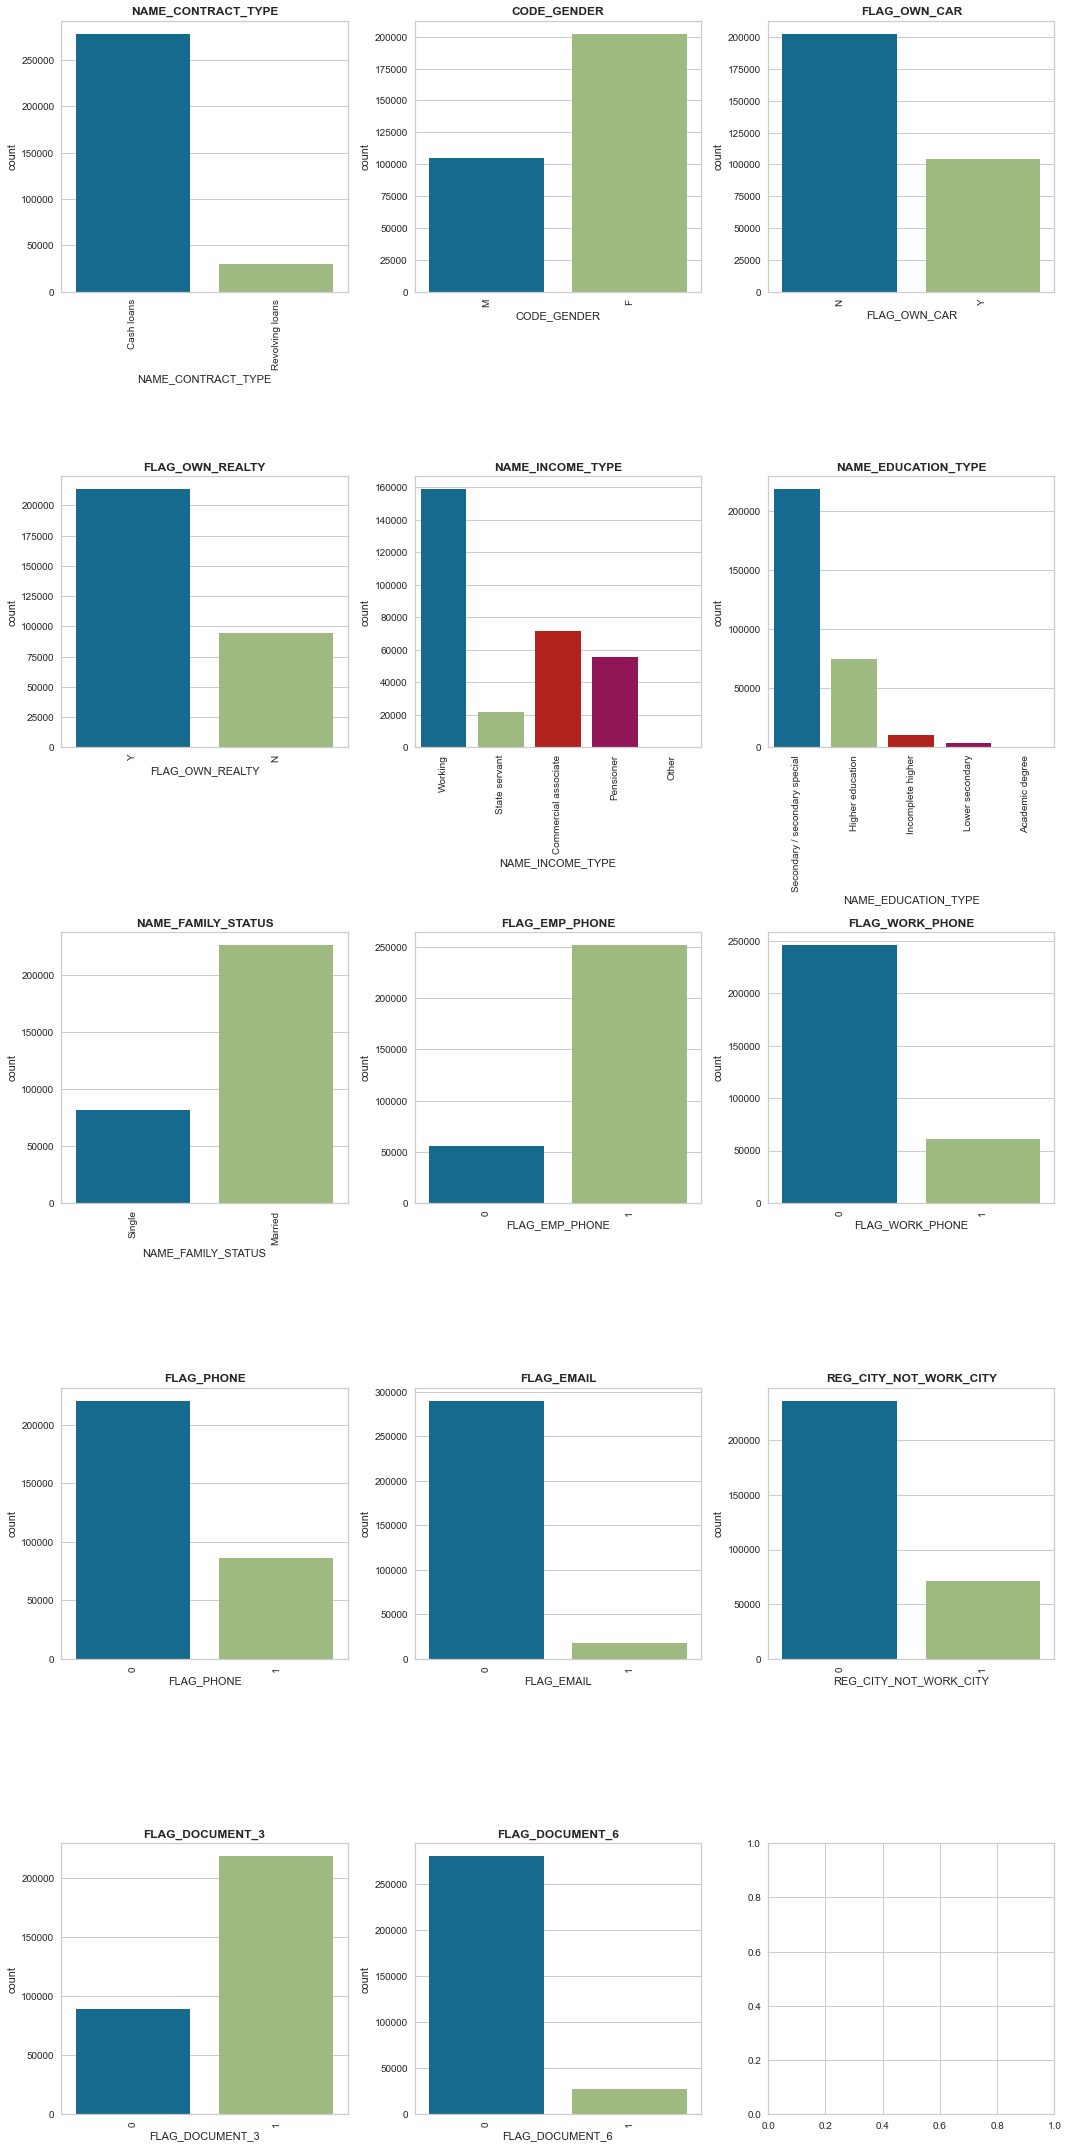

In [25]:
#PLOT DEFINITIVE CATEGORIC VARIABLES
fig, ax = plt.subplots(5, 3, figsize=(15, 30))
#fig.suptitle('CATEGORICAL FEATURES')
for variable, subplot in zip(categorical, ax.flatten()):
    ax=sns.countplot(df[variable], ax=subplot)
    #ax.set_title(variable)
    ax=ax.set_title(variable,fontsize = 12, fontweight='bold')
    
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.tight_layout()

## NUMERCIAL FEATURES

In [26]:
df['TARGET']=df['TARGET'].astype('category')
df=df.drop(labels='SK_ID_CURR',axis=1)

In [27]:
numerical_features = df.select_dtypes("int64").columns.to_list()
numerical_features = numerical_features+df.select_dtypes("float64").columns.to_list()
print(numerical_features,len(numerical_features))

['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'] 34


In [28]:
#Make sure we not have categorial features(dummies)
df[numerical_features].apply(pd.Series.nunique, axis = 0)

CNT_CHILDREN                        15
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_ID_PUBLISH                   6168
REGION_RATING_CLIENT                 3
REGION_RATING_CLIENT_W_CITY          3
HOUR_APPR_PROCESS_START             24
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
REGION_POPULATION_RELATIVE          81
DAYS_REGISTRATION                15688
CNT_FAM_MEMBERS                     17
EXT_SOURCE_2                    119829
EXT_SOURCE_3                       814
YEARS_BEGINEXPLUATATION_AVG        285
FLOORSMAX_AVG                      403
YEARS_BEGINEXPLUATATION_MODE       221
FLOORSMAX_MODE                      25
YEARS_BEGINEXPLUATATION_MEDI       245
FLOORSMAX_MEDI                      49
TOTALAREA_MODE                    5116
OBS_30_CNT_SOCIAL_CIRCLE            33
DEF_30_CNT_SOCIAL_CIRCLE            10
OBS_60_CNT_SOCIAL_CIRCLE 

In [29]:
df[numerical_features].describe(include='all')

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307505.00000,307505.000000,307505.000000,307505.000000,307505.000000,307505.000000,307505.000000,3.075050e+05,3.075050e+05,307493.000000,...,306484.000000,306484.000000,306484.000000,307504.000000,265987.000000,265987.000000,265987.000000,265987.000000,265987.000000,265987.000000
mean,0.41705,-16037.049495,63816.348794,-2994.201437,2.052461,2.031518,12.063378,1.687967e+05,5.990284e+05,27108.638224,...,0.143407,1.405251,0.100035,-962.861833,0.006403,0.007000,0.034363,0.267389,0.265475,1.899954
std,0.72212,4363.987877,141276.836143,1509.454886,0.509036,0.502739,3.265840,2.371248e+05,4.024939e+05,14493.840051,...,0.446645,2.379750,0.362222,826.813977,0.083850,0.110758,0.204687,0.915995,0.794061,1.869288
min,0.00000,-25229.000000,-17912.000000,-7197.000000,1.000000,1.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,-19682.000000,-2760.000000,-4299.000000,2.000000,2.000000,10.000000,1.125000e+05,2.700000e+05,16524.000000,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,-15750.000000,-1213.000000,-3254.000000,2.000000,2.000000,12.000000,1.471500e+05,5.135310e+05,24903.000000,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.00000,-12413.000000,-289.000000,-1720.000000,2.000000,2.000000,14.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.00000,-7489.000000,365243.000000,0.000000,3.000000,3.000000,23.000000,1.170000e+08,4.050000e+06,258025.500000,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [30]:
numerical_missing = []
for col in numerical_features:
        numerical_missing.append(df[col].isnull().sum() * 100 / len(df))
        
numerical_missing=pd.DataFrame({'column_name': numerical_features,'percent_missing': numerical_missing})
numerical_missing.sort_values('percent_missing',ascending=False, inplace=True)
numerical_missing

,column_name,percent_missing
17,FLOORSMAX_AVG,49.761142
21,FLOORSMAX_MEDI,49.761142
19,FLOORSMAX_MODE,49.761142
20,YEARS_BEGINEXPLUATATION_MEDI,48.781321
18,YEARS_BEGINEXPLUATATION_MODE,48.781321
16,YEARS_BEGINEXPLUATATION_AVG,48.781321
22,TOTALAREA_MODE,48.268809
15,EXT_SOURCE_3,19.825369
32,AMT_REQ_CREDIT_BUREAU_QRT,13.501569
31,AMT_REQ_CREDIT_BUREAU_MON,13.501569


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

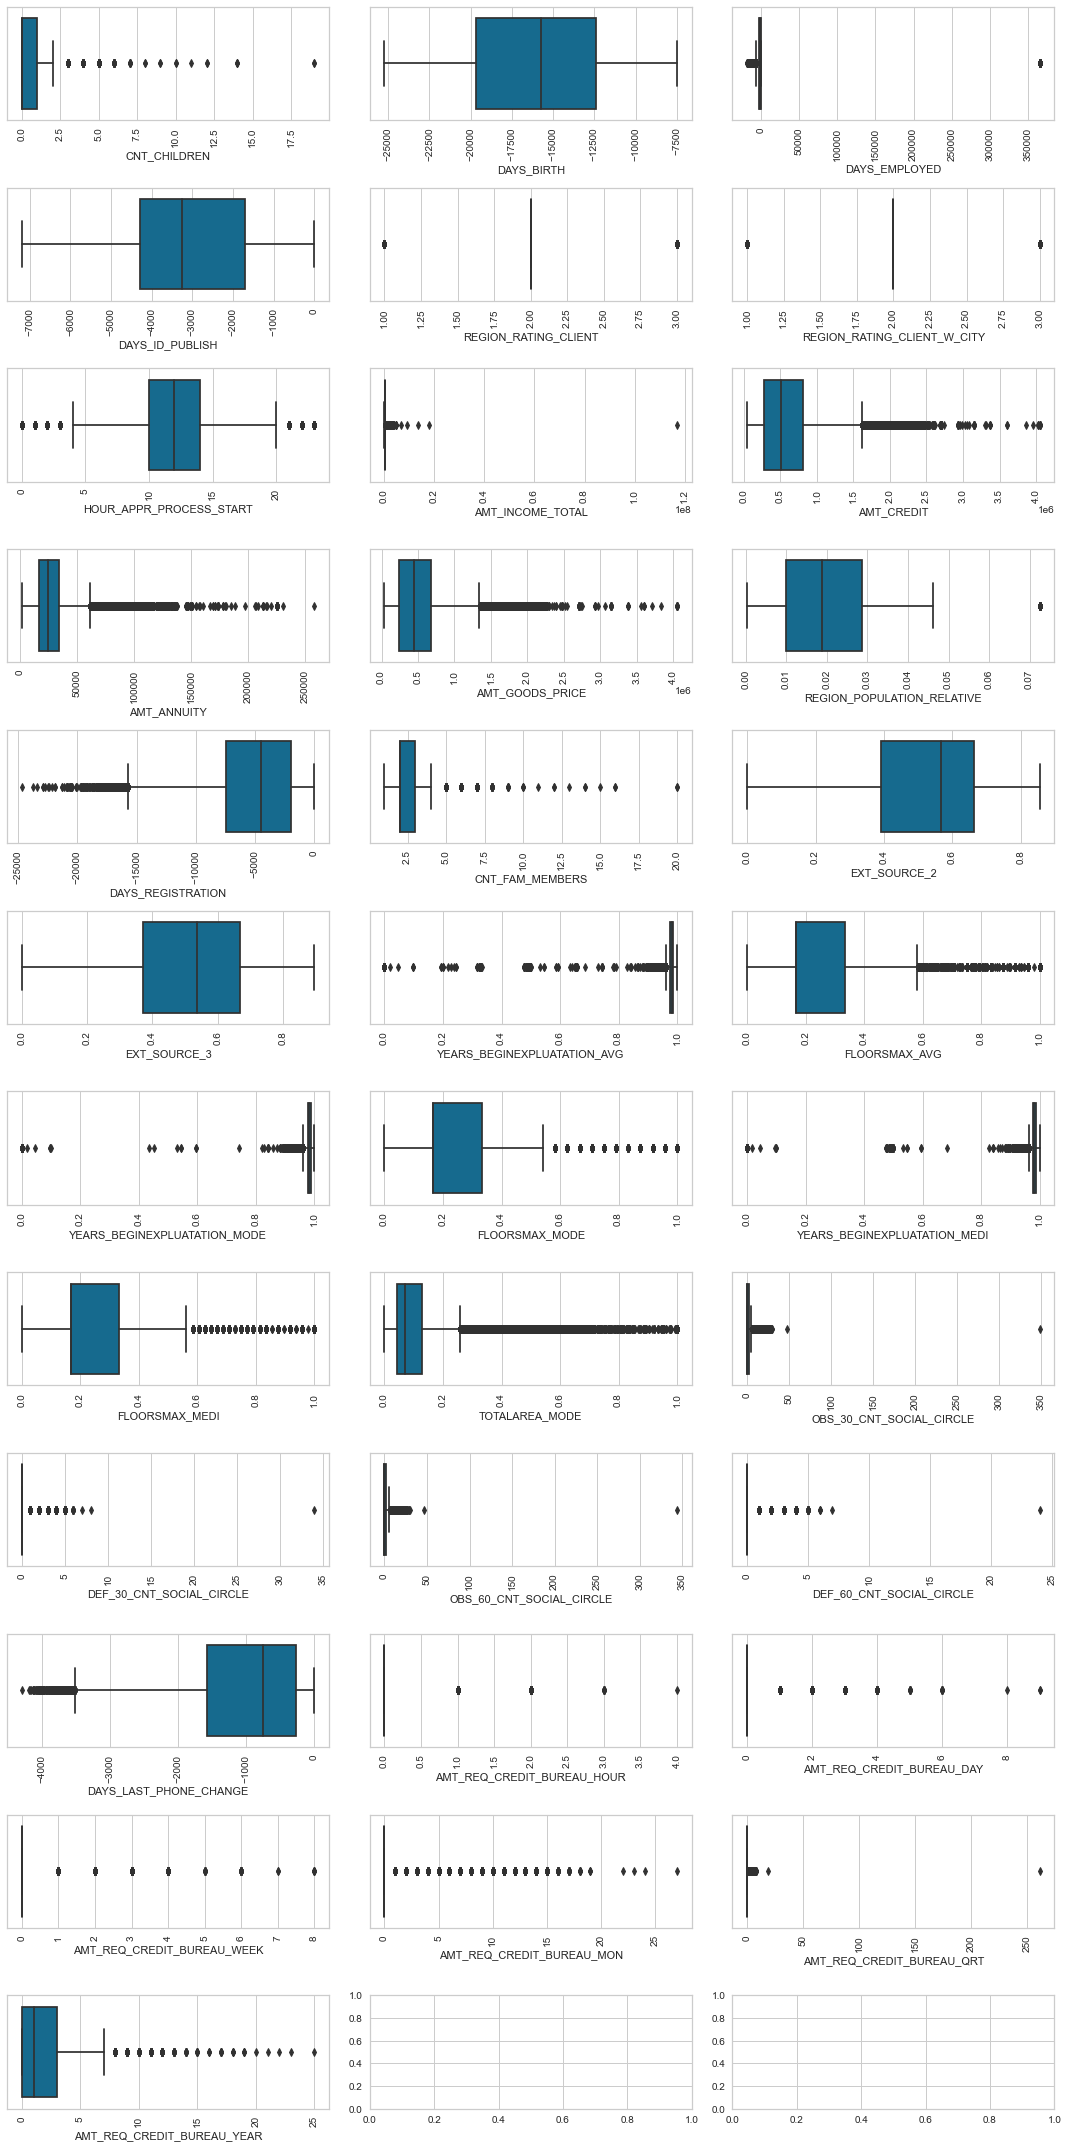

In [31]:
# PLOT NUMERICAL FEATURES
fig, ax = plt.subplots(12, 3, figsize=(15, 30))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.tight_layout()

In [32]:
# USING THE DESCRIPTION 
pd.set_option('display.max_colwidth', None)  
print(description_labels['Description'][description_labels['Row'] == 'AMT_REQ_CREDIT_BUREAU_HOUR'])

116    Number of enquiries to Credit Bureau about the client one hour before application
Name: Description, dtype: object


In [33]:
df['AMT_REQ_CREDIT_BUREAU_DAY'].describe(include='all')

count    265987.000000
mean          0.007000
std           0.110758
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

### DATA PREPARATION NUMERICAL FEATURES

In [34]:
## DROP FEATURES THAT HAVE HIGH % MISSING VALUES OR NOT RELATED TO CREDIT RISK
unusable_numerical=['HOUR_APPR_PROCESS_START','DAYS_ID_PUBLISH','DAYS_REGISTRATION','YEARS_BEGINEXPLUATATION_AVG', 
                    'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
                    'FLOORSMAX_MEDI', 'TOTALAREA_MODE','DAYS_LAST_PHONE_CHANGE']

#drop non usable
for col in unusable_numerical: del df[col]

In [35]:
#Atyphical data 'CNT_CHILDREN'
quant=df['CNT_CHILDREN'].quantile(.99)
df['CNT_CHILDREN']=df['CNT_CHILDREN'].map(lambda x: quant if x > quant else x)

#Convert days to years
df['DAYS_BIRTH']=round(abs(df['DAYS_BIRTH'])/365 ,0)

#Convert days to years and atyphical data 'DAYS_EMPLOYED'
quant=df['DAYS_EMPLOYED'].quantile(.81)
df['DAYS_EMPLOYED']=round(abs(df['DAYS_EMPLOYED'])/365 ,0)

#Atyphical data 'CNT_FAM_MEMBERS'
quant=df['CNT_FAM_MEMBERS'].quantile(.99)
df['CNT_FAM_MEMBERS']=df['CNT_FAM_MEMBERS'].map(lambda x: quant if x > quant else x)

#Drop rows by columns nan values
df=df.dropna(subset=['AMT_ANNUITY'])
df=df.dropna(subset=['AMT_GOODS_PRICE'])
df=df.dropna(subset=['EXT_SOURCE_2'])
df=df.dropna(subset=['EXT_SOURCE_3'])

#Impute 0 in Nan values
df=df.replace(np.nan, 0)

In [36]:
#make sure we dont have missing values
numerical = df.select_dtypes("int64").columns.to_list()
numerical = numerical+df.select_dtypes("float64").columns.to_list()
numerical_missing = []
for col in numerical:
        numerical_missing.append(df[col].isnull().sum() * 100 / len(df))
        
numerical_missing=pd.DataFrame({'column_name': numerical,'percent_missing': numerical_missing})
numerical_missing

,column_name,percent_missing
0,REGION_RATING_CLIENT,0.0
1,REGION_RATING_CLIENT_W_CITY,0.0
2,CNT_CHILDREN,0.0
3,AMT_INCOME_TOTAL,0.0
4,AMT_CREDIT,0.0
5,AMT_ANNUITY,0.0
6,AMT_GOODS_PRICE,0.0
7,REGION_POPULATION_RELATIVE,0.0
8,DAYS_BIRTH,0.0
9,DAYS_EMPLOYED,0.0


#### CORRELATION

**Take a look of correlation between numerical features is helpfull to avoid a posible overfit caused by two or more features that explain the same behavior**

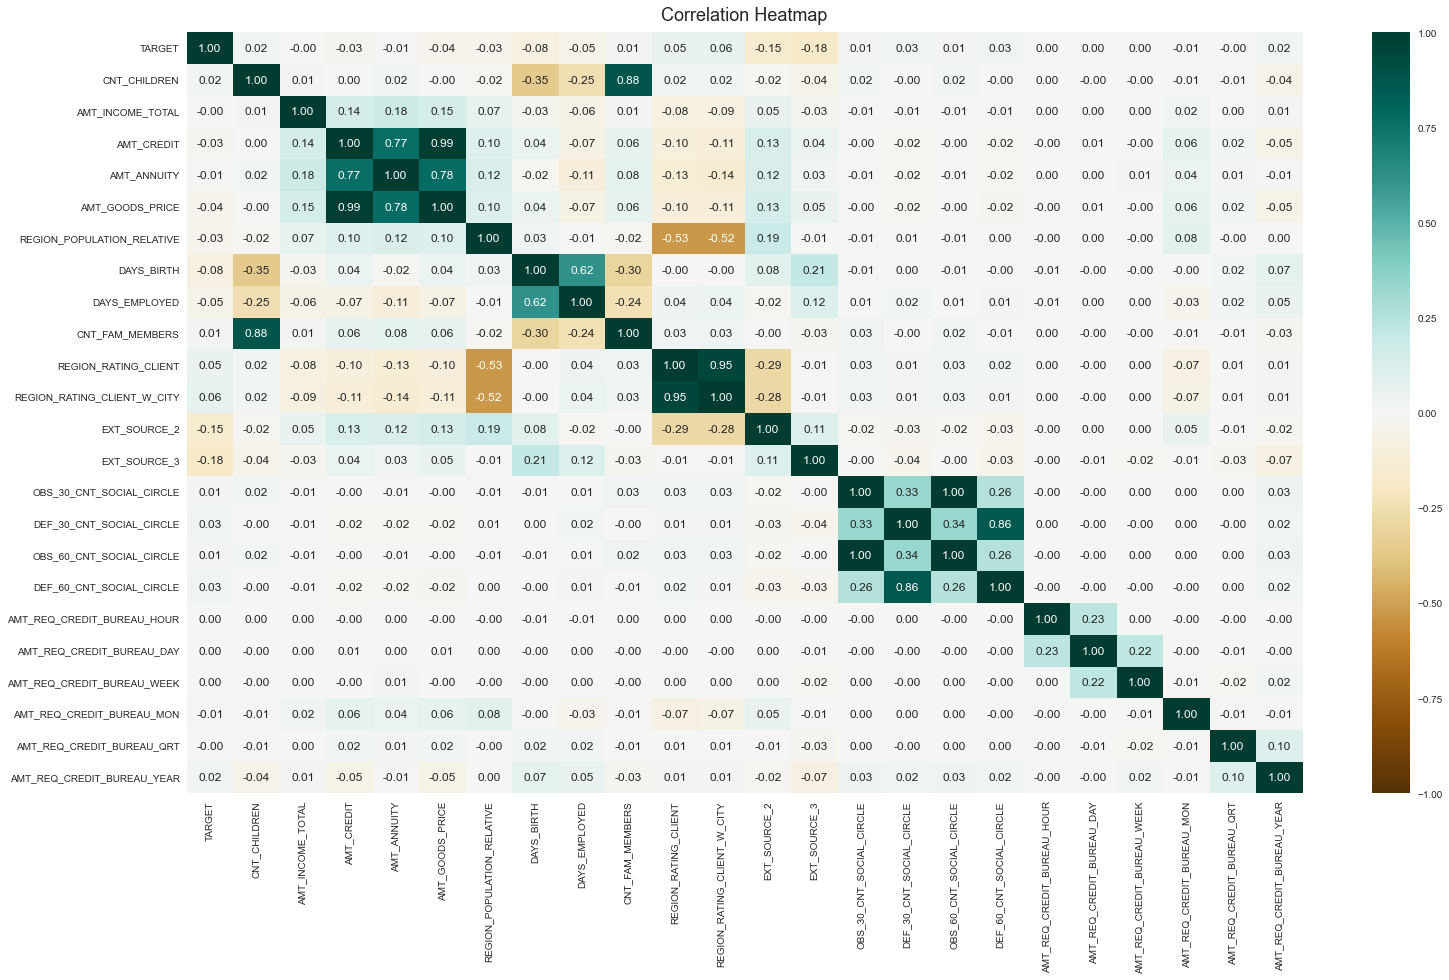

In [37]:
df['TARGET']=df['TARGET'].astype('int64')
numerical= df.select_dtypes(include=['float64', 'int64']).columns.to_list() # get the numerical feature name
plt.figure(figsize=(25,14))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df[numerical].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',fmt='.2f')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [38]:
#DROP HIGH CORRELATION FEATURES
df=df.drop(labels=['CNT_FAM_MEMBERS'],axis=1)
df=df.drop(labels=['AMT_GOODS_PRICE'],axis=1)
df=df.drop(labels=['REGION_RATING_CLIENT_W_CITY'],axis=1)
df=df.drop(labels=['DEF_60_CNT_SOCIAL_CIRCLE'],axis=1)

In [39]:
numerical= df.select_dtypes(include=['float64', 'int64']).columns.to_list()
len(numerical)

20

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

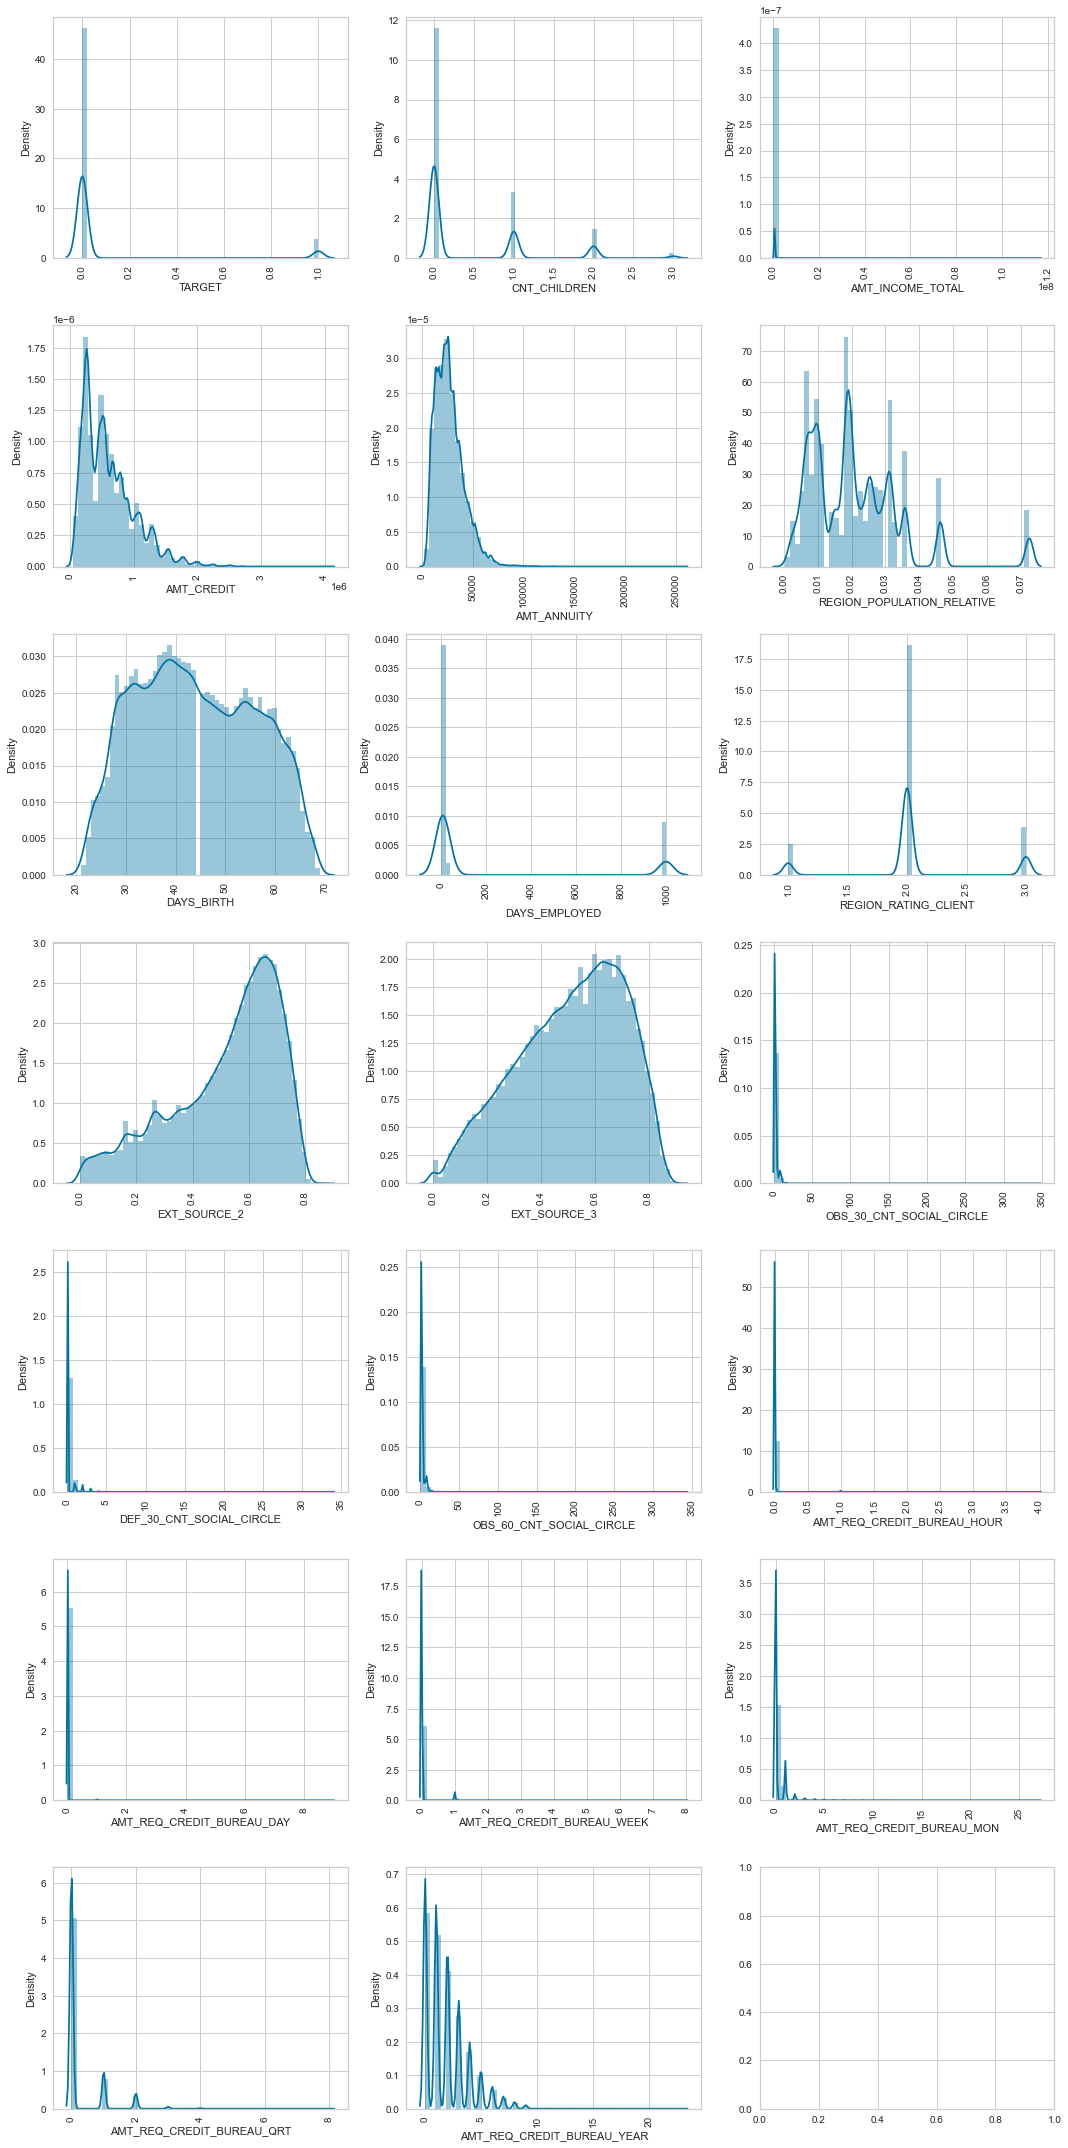

In [40]:
#PLOT DEFINITIVE NUMERICAL VARIABLES
fig, ax = plt.subplots(7, 3, figsize=(15, 30))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.distplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
fig.tight_layout()

In [41]:
print('defaulters percentage is',df['TARGET'].sum()*100/df.shape[0],'%')
print('Female percentage is',df['CODE_GENDER'][df['CODE_GENDER']=='F'].count()*100/df.shape[0],'%')

defaulters percentage is 7.766856045971589 %
Female percentage is 66.43960128674901 %


In [42]:
print('The number of numerical features is',len(numerical))
print('The number of categorical features is',len(categorical))

The number of numerical features is 20
The number of categorical features is 14


### Implementation OneHotEncoder

In [43]:
data=df.reset_index(drop=True)
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,Working,...,2.0,2.0,1,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,Working,...,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Cash loans,M,N,Y,0.0,99000.0,490495.5,27517.5,State servant,...,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0,1.0
3,0,Cash loans,F,Y,Y,1.0,171000.0,1560726.0,41301.0,Commercial associate,...,0.0,1.0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
4,0,Cash loans,M,Y,Y,0.0,360000.0,1530000.0,42075.0,State servant,...,0.0,2.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
data.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,245891.000000,245891.000000,2.458910e+05,2.458910e+05,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000
mean,0.077669,0.421634,1.720400e+05,6.084685e+05,27186.379601,0.020769,44.198531,185.405354,2.054016,0.518592,0.510808,1.431301,0.143897,1.414554,0.006413,0.006901,0.034361,0.275996,0.263751,1.896999
std,0.267650,0.711995,2.568721e+05,4.048809e+05,14333.557448,0.013694,11.784823,381.726237,0.502394,0.189061,0.194856,2.420645,0.447366,2.399638,0.083997,0.110369,0.203997,0.939831,0.609430,1.860032
min,0.000000,0.000000,2.610000e+04,4.500000e+04,1615.500000,0.000290,21.000000,0.000000,1.000000,0.000001,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.745000e+05,16677.000000,0.010006,35.000000,3.000000,2.000000,0.401119,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.575000e+05,5.212800e+05,25015.500000,0.018850,43.000000,6.000000,2.000000,0.570147,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.140410e+05,34767.000000,0.028663,54.000000,16.000000,2.000000,0.665246,0.669057,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,3.000000,1.170000e+08,4.050000e+06,258025.500000,0.072508,69.000000,1001.000000,3.000000,0.855000,0.896010,348.000000,34.000000,344.000000,4.000000,9.000000,8.000000,27.000000,8.000000,23.000000


In [45]:
categorical_features = data.select_dtypes("object").columns.to_list()
categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6']

In [46]:
df_cat=data[categorical_features]
df_cat.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6
0,Cash loans,M,N,Y,Working,Secondary / secondary special,Single,1,0,1,0,0,1,0
1,Revolving loans,M,Y,Y,Working,Secondary / secondary special,Single,1,1,1,0,0,0,0


In [47]:
df_cat.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6
count,245891,245891,245891,245891,245891,245891,245891,245891,245891,245891,245891,245891,245891,245891
unique,2,2,2,2,5,5,2,2,2,2,2,2,2,2
top,Cash loans,F,N,Y,Working,Secondary / secondary special,Married,1,0,0,0,0,1,0
freq,223171,163369,159753,169684,126637,172993,182585,201706,197036,175253,231530,190540,175621,224278


In [48]:
enc = OneHotEncoder(drop='if_binary').fit(df_cat)
df_out = enc.transform(df_cat).toarray()
categorical_names = enc.get_feature_names_out(['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_6'])
d=pd.DataFrame(df_out, columns=categorical_names)

In [49]:
d.describe()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,...,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Single,FLAG_EMP_PHONE_1,FLAG_WORK_PHONE_1,FLAG_PHONE_1,FLAG_EMAIL_1,REG_CITY_NOT_WORK_CITY_1,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_6_1
count,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,...,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000,245891.000000
mean,0.092399,0.335604,0.350310,0.690078,0.230322,0.000094,0.179669,0.074903,0.515013,0.000557,...,0.011554,0.703535,0.257456,0.820307,0.198686,0.287274,0.058404,0.225104,0.714223,0.087897
std,0.289588,0.472202,0.477068,0.462462,0.421040,0.009671,0.383912,0.263235,0.499776,0.023598,...,0.106867,0.456699,0.437233,0.383933,0.399012,0.452491,0.234506,0.417652,0.451785,0.283145
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
#Getting Labels
d.columns.to_list()

['NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Other',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Single',
 'FLAG_EMP_PHONE_1',
 'FLAG_WORK_PHONE_1',
 'FLAG_PHONE_1',
 'FLAG_EMAIL_1',
 'REG_CITY_NOT_WORK_CITY_1',
 'FLAG_DOCUMENT_3_1',
 'FLAG_DOCUMENT_6_1']

# PIPELINES

In [51]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]

In [52]:
# get the categorical feature names
One_Hot_Encoder = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop='if_binary'),list(range(len(categorical))))
])

In [53]:
# Create the X feature matrix 
X = data.drop(labels='TARGET', axis=1)
#and the y target vector
y = data['TARGET']
# global variables
seed = 108

In [54]:
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
y = y.astype('category')
y

0         1
1         0
2         0
3         0
4         0
         ..
245886    0
245887    0
245888    0
245889    1
245890    0
Name: TARGET, Length: 245891, dtype: category
Categories (2, int64): [0, 1]

In [55]:
num_features = X.select_dtypes(include=['float64', 'int64']).columns.to_list()
num_features

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [56]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()
numerical_features = numerical_features+X.select_dtypes("float64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    #('cat_transformer', CategoricalTransformer()),
    ('encoder',One_Hot_Encoder)#OneHotEncoder,CategoricalTransformer
]
# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),#StandardScaler() ,RobustScaler()
]
# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

In [57]:
pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

In [58]:
new_categorical_features=['NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Other',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Single',
 'FLAG_EMP_PHONE_1',
 'FLAG_WORK_PHONE_1',
 'FLAG_PHONE_1',
 'FLAG_EMAIL_1',
 'REG_CITY_NOT_WORK_CITY_1',
 'FLAG_DOCUMENT_3_1',
 'FLAG_DOCUMENT_6_1']
columnas=new_categorical_features + numerical_features #Labels for XG Boost
len(columnas)

41

In [59]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True, stratify=y)

In [60]:
y_test1=y_test.astype('int64')
y_train1=y_train.astype('int64')

In [61]:
# we pass the preprocessing pipeline as a step to the full pipeline
new_X_train = preprocessing_pipeline.fit_transform(X_train)
new_X_train = pd.DataFrame(new_X_train, columns=columnas)
new_X_train.columns.tolist()

['NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Other',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Single',
 'FLAG_EMP_PHONE_1',
 'FLAG_WORK_PHONE_1',
 'FLAG_PHONE_1',
 'FLAG_EMAIL_1',
 'REG_CITY_NOT_WORK_CITY_1',
 'FLAG_DOCUMENT_3_1',
 'FLAG_DOCUMENT_6_1',
 'REGION_RATING_CLIENT',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 

In [62]:
new_X_train.describe()

,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,172123.000000,...,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05,1.721230e+05
mean,0.092904,0.334865,0.350058,0.690396,0.230167,0.000070,0.180667,0.075475,0.513621,0.000540,...,-2.078246e-16,-4.493448e-17,-2.792667e-17,2.649215e-17,3.723556e-17,2.304002e-17,2.033094e-17,-6.628197e-17,8.046719e-17,4.291945e-17
std,0.290299,0.471945,0.476989,0.462332,0.420941,0.008349,0.384743,0.264157,0.499816,0.023238,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.618842e+00,-5.804139e-01,-3.209591e-01,-5.787212e-01,-7.575546e-02,-6.240314e-02,-1.697015e-01,-2.929944e-01,-4.333587e-01,-1.020595e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.183918e-01,-5.804139e-01,-3.209591e-01,-5.787212e-01,-7.575546e-02,-6.240314e-02,-1.697015e-01,-2.929944e-01,-4.333587e-01,-1.020595e+00
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.269088e-01,-5.804139e-01,-3.209591e-01,-5.787212e-01,-7.575546e-02,-6.240314e-02,-1.697015e-01,-2.929944e-01,-4.333587e-01,-4.839081e-01
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,8.056148e-01,2.297373e-01,-3.209591e-01,2.385380e-01,-7.575546e-02,-6.240314e-02,-1.697015e-01,-2.929944e-01,-4.333587e-01,5.894664e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.979149e+00,1.403859e+02,7.557040e+01,1.399899e+02,4.835231e+01,7.950067e+01,3.915649e+01,2.826787e+01,1.270464e+01,1.078652e+01


In [63]:
# create a default XGBoost classifier objective='binary:logistic',
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8],
    "subsample": [0.6, 0.8],
    "max_depth": [2, 4, 6],
    "n_estimators": [100, 200, 300],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed,shuffle=True)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
best_xgb = grid.fit(new_X_train,y_train1)

In [64]:
print(best_xgb.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              eval_metric=['error', 'auc'], gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=108,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [65]:
xgb_model=best_xgb.best_estimator_ #guardar xgboost

In [66]:
xgb_model.get_booster().feature_names #nombres variables

['NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Other',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Single',
 'FLAG_EMP_PHONE_1',
 'FLAG_WORK_PHONE_1',
 'FLAG_PHONE_1',
 'FLAG_EMAIL_1',
 'REG_CITY_NOT_WORK_CITY_1',
 'FLAG_DOCUMENT_3_1',
 'FLAG_DOCUMENT_6_1',
 'REGION_RATING_CLIENT',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 

### SAVE MODEL AND PIPELINE


In [67]:
dump(xgb_model,open('pickle_xgbproject4.pkl','wb'))  #Guardar modelo

In [68]:
dump(preprocessing_pipeline,open('pickle_pipelinexgbproject4.pkl','wb')) #Guardar pipeline

#### TEST

In [69]:
# we pass the preprocessing pipeline as a step to the full pipeline for test
new_X_test = preprocessing_pipeline.transform(X_test) #transform
new_X_test = pd.DataFrame(new_X_test, columns=columnas)

In [70]:
#test
pred_test = xgb_model.predict(new_X_test)
pred_train = xgb_model.predict(new_X_train) 
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.9235023791126113
Test Accuraccy:  0.9223782669992409

Confusion Matrix:
[[67935   104]
 [ 5622   107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     68039
           1       0.51      0.02      0.04      5729

    accuracy                           0.92     73768
   macro avg       0.72      0.51      0.50     73768
weighted avg       0.89      0.92      0.89     73768



# Model Evaluation and Validation

could not determine class_counts_ from previously fitted classifier


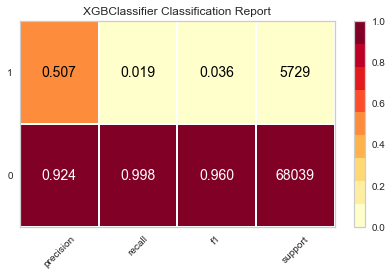

In [71]:
fig, ax = plt.subplots(figsize=(6,4))
visualizer = ClassificationReport(xgb_model, classes=['0','1'], support=True,fmt='.2f')
visualizer.score(new_X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

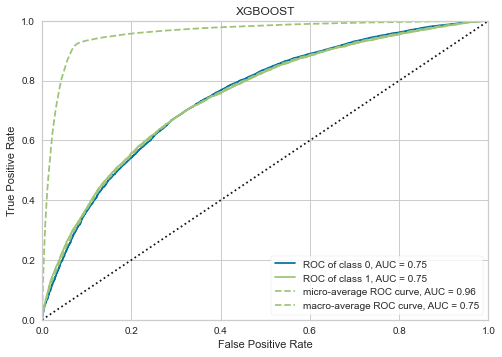

<AxesSubplot:title={'center':'XGBOOST'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [72]:
##ROCAUC

viz =ROCAUC(xgb_model,title="XGBOOST") #best_xgb , xgb_model

viz.fit(new_X_train,y_train1)#new_X_train,y_train1  #new_X_test,y_test1
viz.score(new_X_test,y_test1)#new_X_train,y_train1  #new_X_test,y_test1
viz.show()

**We are getting a AUC=0.75, the academic articles say that if an AUC is above  0.7 the model is okay**

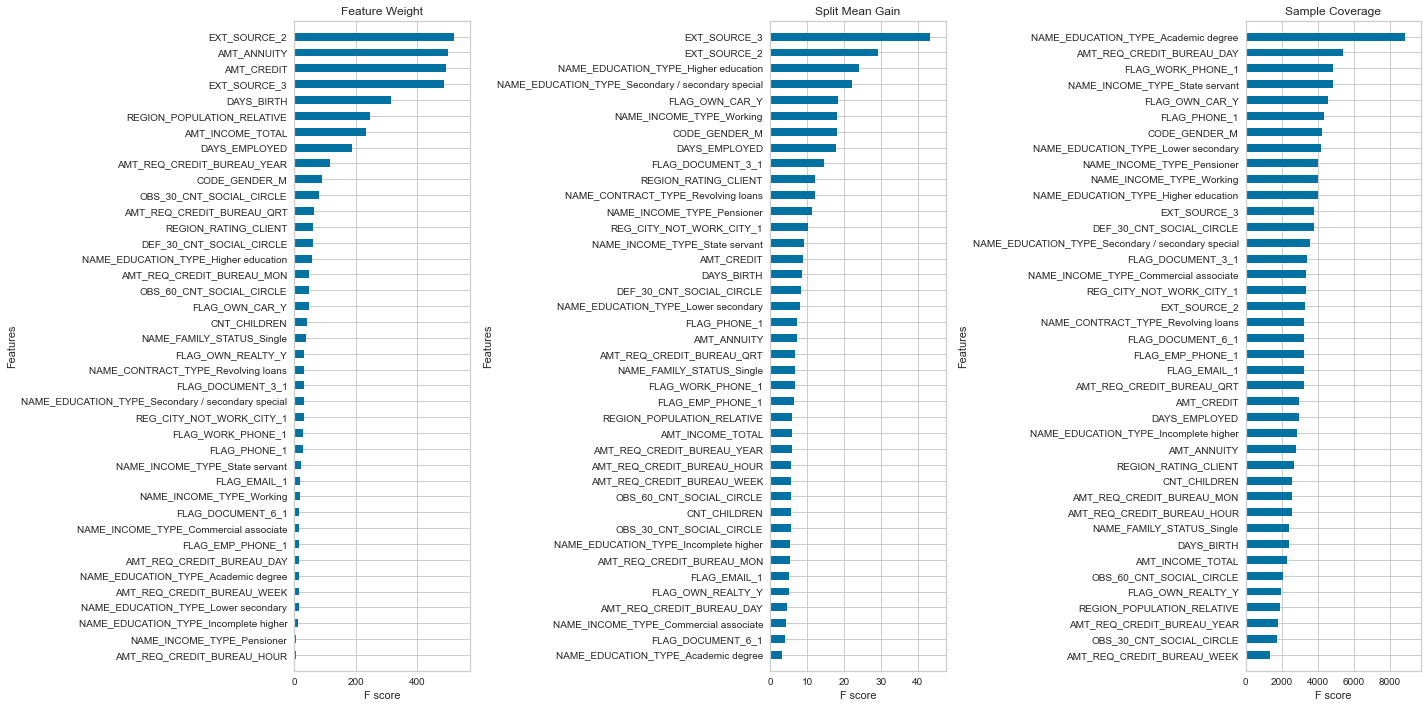

In [73]:
# saving the feature names to the model
xgb_model.get_booster().feature_names = columnas
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(20,10))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgb_model, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgb_model,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgb_model,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

Feature Weight:	The weight of each feature in the model

Split Mean Gain: Implies the relative contribution of the corresponding characteristic to the model calculated by taking the contribution of each characteristic for each tree in the model. A higher value for this metric compared to another characteristic means that it is more important for generating a prediction.

Sample Coverage: Means the relative number of observations related to this characteristic.

In [74]:
#UNDERSTANDING THE BLACK-BOX WITH SHAP VALUES
shap.initjs()
explainer=shap.TreeExplainer(xgb_model)
shap_values=explainer.shap_values(new_X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


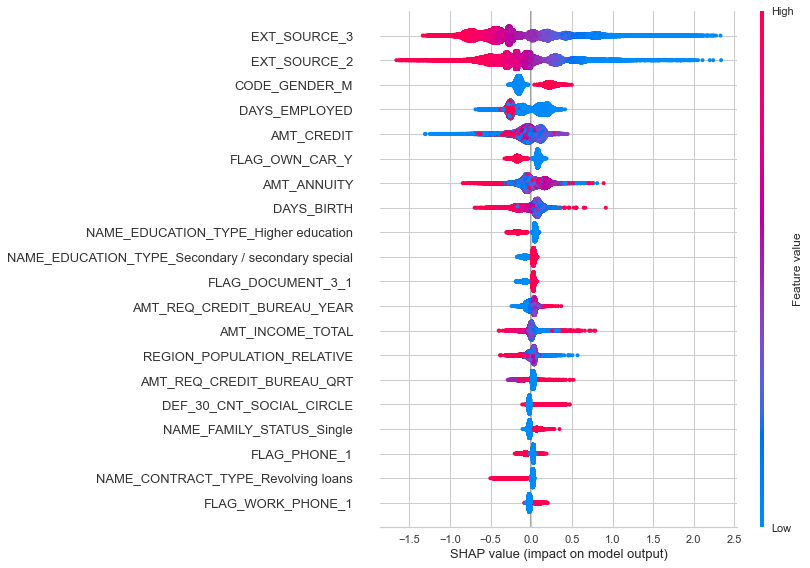

In [75]:
shap.summary_plot(shap_values, new_X_test)